In [45]:
#import standard libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "plotly_mimetype"
from plotly.subplots import make_subplots
import scikit_posthocs as sp
import importlib 
from tqdm import tqdm

In [2]:
#custom function files
import plotter as pt
import mt_utils as ut

In [3]:
importlib.reload(pt)

<module 'plotter' from 'E:\\Melli\\HU\\Masterarbeit Save\\Implementation\\plotter.py'>

In [4]:
importlib.reload(ut) 

<module 'mt_utils' from 'E:\\Melli\\HU\\Masterarbeit Save\\Implementation\\mt_utils.py'>

In [5]:
#import claspy
from claspy.data_loader import load_tssb_dataset
from claspy.data_loader import load_has_dataset
from claspy.segmentation import BinaryClaSPSegmentation

In [6]:
tssb = load_tssb_dataset()
hasc = load_has_dataset()

In [7]:
# compression ratios
crs = np.round(np.arange(0.1,1,0.1),1)
# column titles etc.
algos = ["MinMax","MinMaxLTTB","M4","LTTB", "EveryNth","LTD"]
columns = ['Algorithm', 'compression', 'orig_TS_ID', 'Time_Series', 'True_CPS']
columns_clasp = ['Algorithm', 'compression', 'window_size', 'orig_TS_ID', 'Time_Series', 'True_CPS', 'predicted_cps', 'score', 'runtime']

# Splitting

In [ ]:
# split time series in datasets at change points
def prepare_splits(dataset):
    results = []
    for index, row in tqdm(dataset.iterrows(), total=len(dataset), desc="Processing rows"):

        # univariate TS
        if row.time_series.ndim > 1:
            ts_arr = np.transpose(row.time_series)
            splits = ut.split_ts(ts_arr, row.cps)
        else:
            splits = ut.split_ts(np.expand_dims(row.time_series, axis=0), row.cps)

        # multivariate: split and downsample each time series
        for algo in algos:
            for cr in crs:
                ds_ts_list = []
                
                for split in splits:
                    ds_ts, ds_cps = ut.downsample_splits(algo, split, cr)
                    ds_ts_list.append((ds_ts))
    
                ds_ts = np.array(ds_ts_list).squeeze()
                if row.time_series.ndim > 1:
                    ds_ts = np.transpose(ds_ts)

                results.append((algo, cr, index, ds_ts, ds_cps))
    return results

In [ ]:
results_tssb = prepare_splits(tssb)

In [ ]:
results_df_tssb = pd.DataFrame(results_tssb, columns=columns)
results_df_tssb.to_pickle("results/zwischenergebnisse/1_downsampled_splitting_tssb.pkl")
results_df_tssb

In [ ]:
results_hasc = prepare_splits(hasc)

In [ ]:
results_df_hasc = pd.DataFrame(results_hasc, columns=columns)
results_df_hasc.to_pickle("results/zwischenergebnisse/1_downsampled_splitting_hasc.pkl")
results_df_hasc

# ClaSP on split data

In [8]:
def clasp_segmentation(dataset, downsampled=True):
    import warnings
    warnings.simplefilter("ignore")
    results = []
    for index, row in tqdm(dataset.iterrows(), total=len(dataset), desc="Processing rows"):
        if downsampled:
            w, pred_cps, score, runtime = ut.evaluate_clasp(row.Time_Series, row.True_CPS)            
            results.append((row.Algorithm, row.compression, w, row.orig_TS_ID, row.Time_Series, row.True_CPS, pred_cps, score, runtime))
        else:
            w, pred_cps, score, runtime = ut.evaluate_clasp(row.time_series, row.cps)            
            results.append(('None', 1, w, index, row.time_series, row.cps, pred_cps, score, runtime))
    return results

## TSSB

In [ ]:
results_clasp_tssb = clasp_segmentation(results_df_tssb)

In [ ]:
# clasp on original TS from TSSB
results_clasp_original = clasp_segmentation(tssb, False)

In [ ]:
#append original to downsampled
results_clasp_df_tssb = pd.DataFrame(results_clasp_tssb, columns=columns_clasp)
results_clasp_df_tssb_orig = pd.DataFrame(results_clasp_original, columns=columns_clasp)

results_clasp_df_tssb.orig_TS_ID = results_df_tssb.orig_TS_ID
results_clasp_df_tssb_complete = pd.concat([results_clasp_df_tssb,results_clasp_df_tssb_orig]).reset_index(drop=True)

results_clasp_df_tssb_complete.to_pickle("results/zwischenergebnisse/1a_clasp_splitting_tssb.pkl")
results_clasp_df_tssb_complete

## HASC

In [ ]:
results_clasp_hasc = clasp_segmentation(results_df_hasc)

In [ ]:
results_clasp_original_hasc = clasp_segmentation(hasc, False)

In [ ]:
#append original to downsampled
results_clasp_df_hasc = pd.DataFrame(results_clasp_hasc, columns=columns_clasp)
results_clasp_df_hasc_orig = pd.DataFrame(results_clasp_original_hasc, columns=columns_clasp)

results_clasp_df_hasc_complete = pd.concat([results_clasp_df_hasc,results_clasp_df_hasc_orig]).reset_index(drop=True)

results_clasp_df_hasc_complete.to_pickle("results/zwischenergebnisse/1a_clasp_splitting_hasc.pkl")
results_clasp_df_hasc_complete

# Analysis

## Functions

In [9]:
def group_df(df, column):
    df.groupby([column]).mean()
    return df.groupby([column]).mean(), df.groupby([column]).median()

In [10]:
def plot_clasp_per_compression(df, title, y_title_pre, filepath=None):
    fig = go.Figure()
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    fig.add_trace(go.Scatter(x=df.index.values, y=df.score,
                        mode='lines',
                        line=dict(color='black', width=2),
                        name='Score'),
                 secondary_y=False
                 )
    
    fig.add_trace(go.Scatter(x=df.index.values, y=df.runtime,
                        mode='lines',
                        line=dict(color='grey', width=2, dash='dot'),
                        name='Runtime'),
                 secondary_y=True
                 )
    
    fig.add_vline(x=df['score'].idxmax(), line_width=1, line_color="black", annotation_text="Top Score", annotation_position="top")
    fig.add_vline(x=df['score'].nlargest(2).index[-1], line_width=1, line_color="black", annotation_text="2nd Top Score", annotation_position="top")
    fig.add_vline(x=df['score'].nlargest(3).index[-1], line_width=1, line_color="black", annotation_text="3rd Top Score", annotation_position="top")

    fig.update_yaxes(title_text= y_title_pre + " Covering Score", secondary_y=False)
    fig.update_yaxes(title_text= y_title_pre + " Runtime in Seconds", secondary_y=True)

    fig.update_xaxes(title_text="Compression Ratio")
    
    fig.update_layout(height=300, 
                      font=dict(
                          family="Arial",
                          size=12,
                          color="black"
                      ),
                      title=dict(
                          text=title
                      ),
                      margin=dict(l=0, r=0, t=30, b=0),
                      legend=dict(
                          yanchor="top",
                          y=0.99,
                          xanchor="left", 
                          x=0.01
                      )
                     )

    if filepath:
        fig.write_image(filepath, scale=1, width=1000, height=300)
        
    fig.show()

In [11]:
def critical_distance(df, title=None, filepath=None):
    avg_rank = df.groupby('orig_TS_ID').score.rank(pct=True).groupby(df.Algorithm).mean()
    p_vals = sp.posthoc_nemenyi_friedman(
        df,
        melted=True,
        block_col='orig_TS_ID',
        group_col='Algorithm',
        y_col='score',
    )

    fig = plt.figure(figsize=(10, 2), dpi=100)
    plt.rcParams["font.family"] = "Arial"
    plt.rcParams["font.size"] = "12"
    font = {'family':'arial','color':'black','size':12}
    plt.title(title, loc = 'left', fontdict=font, y=1.2)
    
    sp.critical_difference_diagram(avg_rank, p_vals,
                               label_props={'color': 'black'},
                               elbow_props={'color': 'gray'}                              
                              )
    
    if filepath:
         fig.savefig(filepath, scale=1, bbox_inches='tight')

    plt.show()

## TSSB

In [14]:
grouped_tssb_mean, grouped_tssb_median = group_df(results_clasp_df_tssb_complete, 'compression')

C:\Users\Megaport\AppData\Local\Temp\ipykernel_22324\3689395393.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby([column]).mean()
C:\Users\Megaport\AppData\Local\Temp\ipykernel_22324\3689395393.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  return df.groupby([column]).mean(), df.groupby([column]).median()
C:\Users\Megaport\AppData\Local\Temp\ipykernel_22324\3689395393.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be val

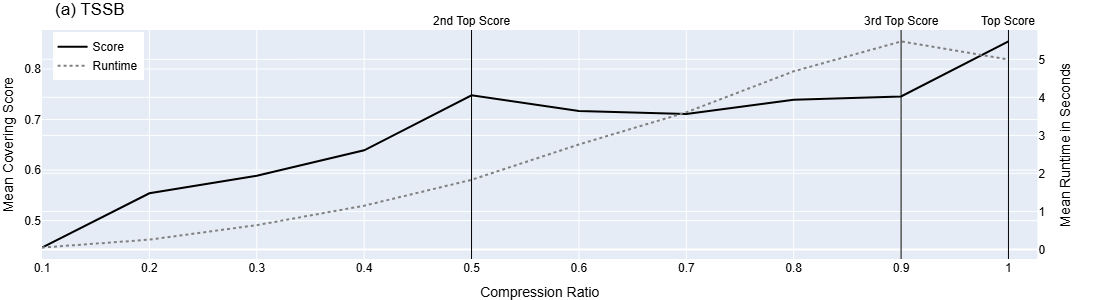

In [50]:
plot_clasp_per_compression(grouped_tssb_mean, title='(a) TSSB', y_title_pre='Mean', filepath="results/figures/mean_scores_runtimes_per_CR_TSSB.svg")

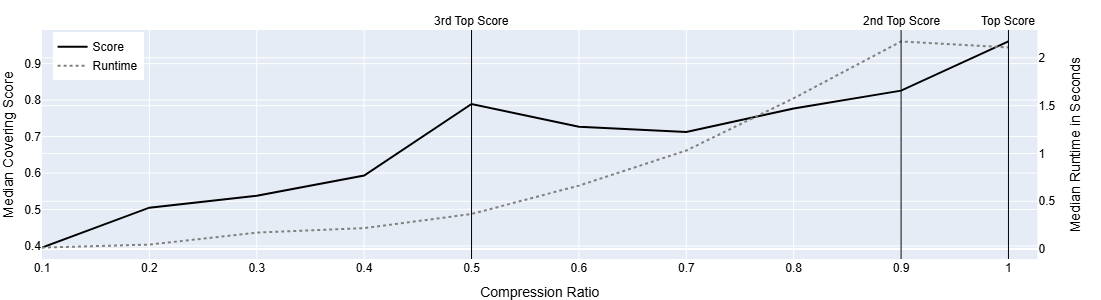

In [49]:
plot_clasp_per_compression(grouped_tssb_median, title='', y_title_pre='Median', filepath="results/figures/median_scores_runtimes_per_CR_TSSB.svg")

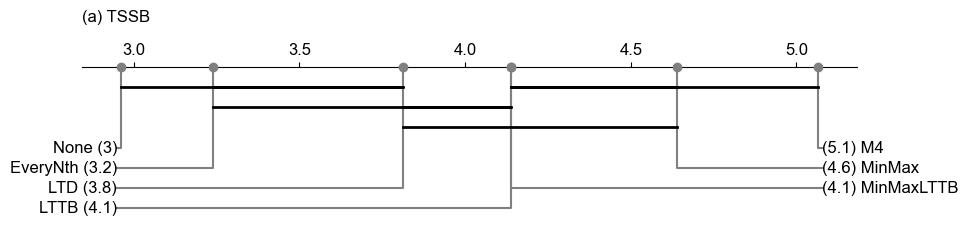

In [17]:
crit_dist = pd.concat([results_clasp_df_tssb_complete[results_clasp_df_tssb_complete.compression==0.5],
                       results_clasp_df_tssb_complete[results_clasp_df_tssb_complete.Algorithm=='None']]).reset_index(drop=True)
pt.critical_distance(crit_dist, title='(a) TSSB', filepath='results/figures/critical_distance_splitting_orig_scores_TSSB.svg')

## HASC

In [18]:
grouped_hasc_mean,grouped_hasc_median = group_df(results_clasp_df_hasc_complete, 'compression')

C:\Users\Megaport\AppData\Local\Temp\ipykernel_22324\3689395393.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

C:\Users\Megaport\AppData\Local\Temp\ipykernel_22324\3689395393.py:3: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

C:\Users\Megaport\AppData\Local\Temp\ipykernel_22324\3689395393.py:3: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



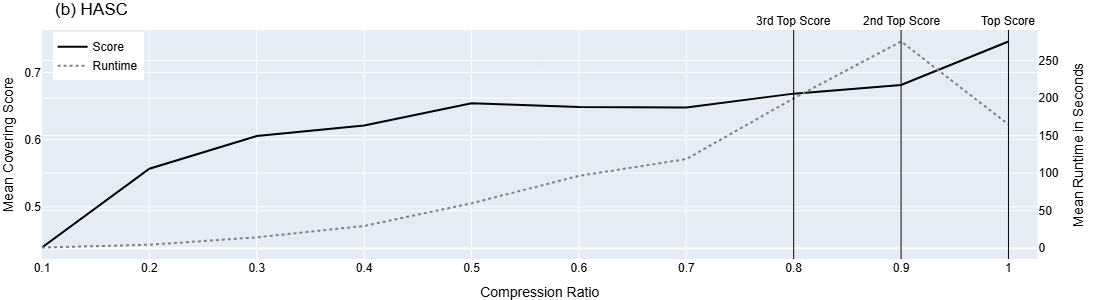

In [48]:
plot_clasp_per_compression(grouped_hasc_mean, title='(b) HASC', y_title_pre='Mean', filepath="results/figures/mean_scores_runtimes_per_CR_HASC.svg")

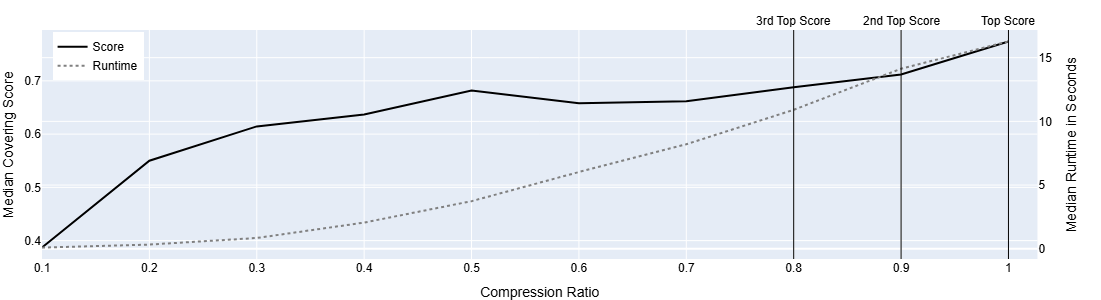

In [47]:
plot_clasp_per_compression(grouped_hasc_median, title='', y_title_pre='Median', filepath="results/figures/median_scores_runtimes_per_CR_HASC.svg")

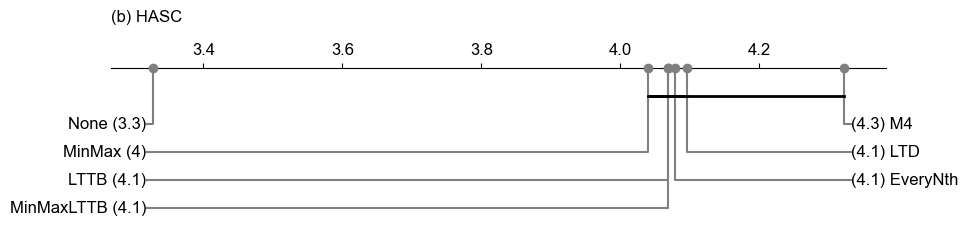

In [21]:
crit_dist = pd.concat([results_clasp_df_hasc_complete[results_clasp_df_hasc_complete.compression==0.5],
                       results_clasp_df_hasc_complete[results_clasp_df_hasc_complete.Algorithm=='None']]).reset_index(drop=True)
pt.critical_distance(crit_dist, title='(b) HASC', filepath='results/figures/critical_distance_splitting_orig_scores_HASC.svg')

# Runtime

## Functions

In [22]:
def add_num_found_cps(row):
    return len(row.predicted_cps)

In [23]:
def add_num_true_cps(row):
    return len(row.True_CPS)

In [24]:
def add_num_cp_diffs(row):
    return row.num_pred_cps-row.num_true_cps

In [25]:
def cp_differences_comparison_matrix(df, save_path=None):
    mean = df.groupby(by=['compression']).mean().rename(columns={'num_pred_cps': 'mean'})
    median = df.groupby(by=['compression']).median().rename(columns={'num_pred_cps': 'median'})
    std = df.groupby(by=['compression']).std().rename(columns={'num_pred_cps': 'std'})
    
    out = mean.merge(median, left_on='compression', right_on='compression')
    out = out.merge(std, left_on='compression', right_on='compression')
    out = out.transpose()
    if save_path:
        out.to_excel(save_path)
    return out

In [44]:
def plot_numCPS_diffs(df_tssb, df_hasc, filepath=None):

    fig = go.Figure(
        layout=dict(
            xaxis=dict(categoryorder="category descending"),
            scattermode="group"
            )
        )

    fig.add_trace(go.Bar(name='TSSB', 
                         x=df_tssb.columns.values, y=df_tssb.loc['mean'].values, 
                         error_y=dict(type='data', array=df_tssb.loc['std'].values)
                        )
                 )
    
    fig.add_trace(go.Bar(name='HASC', 
                         x=df_hasc.columns.values, y=df_hasc.loc['mean'].values, 
                         error_y=dict(type='data', array=df_hasc.loc['std'].values)
                        )
                 )
    
    fig.update_yaxes(title_text="Amount of predicted change points")
    fig.update_xaxes(title_text="Compression Ratio")

    fig.update_layout(height=400, 
                      font=dict(
                          family="Arial",
                          size=12,
                          color="black"
                      ),
                      legend=dict(
                          yanchor="top",
                          y=0.99,
                          xanchor="left", 
                          x=0.01
                      ),
                      xaxis = dict(
                        tickmode = 'array',
                        tickvals = df_tssb.columns.values
                    )
                     )
    
    if filepath:
        fig.write_image(filepath, scale=1, width=1000, height=400)
        
    fig.show()

## TSSB

In [27]:
results_clasp_df_tssb_complete['num_pred_cps'] = results_clasp_df_tssb_complete.apply(add_num_found_cps,axis=1)
results_clasp_df_tssb_complete['num_true_cps'] = results_clasp_df_tssb_complete.apply(add_num_true_cps,axis=1)
results_clasp_df_tssb_complete['diff_pred_true'] = results_clasp_df_tssb_complete.apply(add_num_cp_diffs,axis=1)

In [29]:
cps_tssb=cp_differences_comparison_matrix(results_clasp_df_tssb_complete[['compression','num_pred_cps']], 
                                          save_path='results/tables/NumCPS_per_compression_tssb.xlsx')
cps_tssb

compression,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
mean,0.262222,0.862222,1.591111,1.902222,1.995556,2.624444,2.695556,2.751111,2.575556,2.706667
median,0.000000,0.000000,0.500000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000
std,0.782688,1.576171,2.674954,2.536020,2.072189,3.093758,3.084299,2.949510,3.159435,2.264732


## HASC

In [28]:
results_clasp_df_hasc_complete['num_pred_cps'] = results_clasp_df_hasc_complete.apply(add_num_found_cps,axis=1)
results_clasp_df_hasc_complete['num_true_cps'] = results_clasp_df_hasc_complete.apply(add_num_true_cps,axis=1)
results_clasp_df_hasc_complete['diff_pred_true'] = results_clasp_df_hasc_complete.apply(add_num_cp_diffs,axis=1)

In [30]:
cps_hasc=cp_differences_comparison_matrix(results_clasp_df_hasc_complete[['compression','num_pred_cps']], 
                                          save_path='results/tables/NumCPS_per_compression_hasc.xlsx')
cps_hasc

compression,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
mean,0.658000,1.438000,2.151333,2.695333,2.924000,3.428000,3.69000,3.922000,4.010667,3.43200
median,0.000000,1.000000,1.000000,2.000000,2.000000,2.000000,3.00000,3.000000,3.000000,3.00000
std,1.180098,1.844747,2.604026,3.283753,3.546634,4.405953,4.74323,5.035821,5.239929,3.45908


## Merged Results

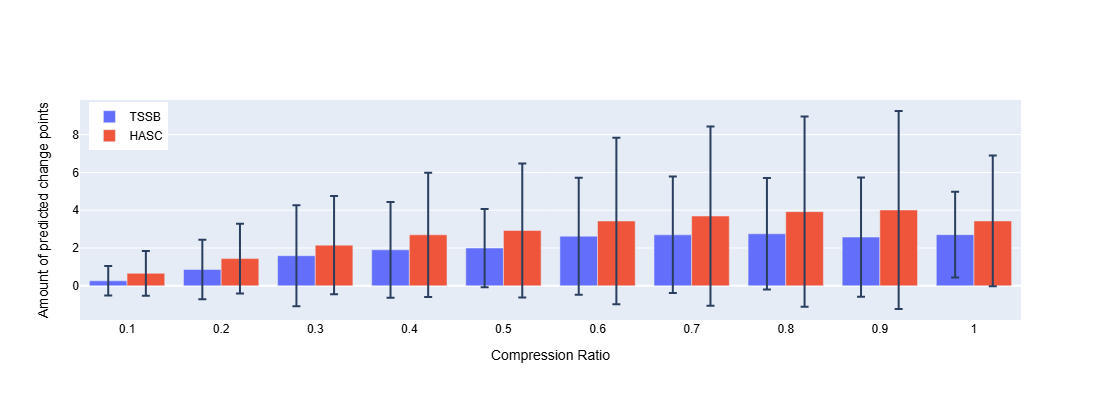

In [46]:
plot_numCPS_diffs(cps_tssb, cps_hasc, filepath='results/figures/Numpredicted_cps_perCR.svg')